# Neuronal Networks and Deep Learning
    
## Stacked Denoising Autoencoder


by 

[__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/)

with examples taken from the scikit-learn documentation under http://scikit-learn.org/stable/


__License__

This work is licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/)


# Introduction

This notebook outlines Stacked Denoising Autoencoders through small examples using python.

# Theory

TODO:

# Toy Example

In this toy example we will take a simple 2D circle and 3D sphere and learn it using a stacked denoising autoencoder.

In [618]:
%pylab inline
import numpy as np
import math
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import mpld3
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']=(14,6)

Populating the interactive namespace from numpy and matplotlib


## Data First: A Circle and a Sphere

In [553]:
def circle(r=[1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((2,num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        d[0,i],d[1,i] = r[0]*math.cos(phi), r[1] * math.sin(phi)
    return d

def sphere(r=[1.0, 1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((3, num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        theta = 2*math.pi*state.rand() # x y angle
        sin_theta = math.sin(theta)
        d[1,i],d[0,i],d[2,i] =r[0] * sin_theta * math.cos(phi), r[1] * sin_theta* math.sin(phi), r[2]*math.cos(theta)
    return d

def scatter3D(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[0], data[1], data[2])
    return fig

def plotae(ae, data):
    pass

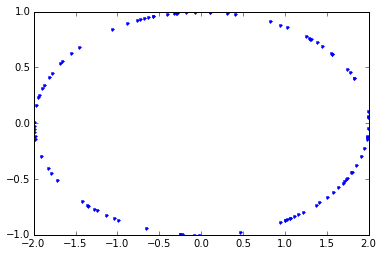

In [79]:
d = circle([2.0,1.0],100)
pl.plot(d[0,],d[1,],".")
pl.show()

In [548]:
data

array([[-0.78008208, -0.08666655, -0.00356945, ..., -0.13371738,
         0.11197294, -0.13611988],
       [-0.625526  ,  0.09278797, -0.01169269, ...,  0.98927638,
         0.12404345,  0.85986707],
       [-0.01375399,  0.9919069 , -0.99992527, ...,  0.058753  ,
         0.98593878, -0.49203658]])

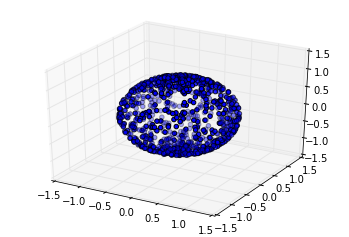

In [556]:
data = sphere([1.0,1.0,1.0],1000)
scatter3D(data).show()

## The Autoencoder

In [88]:
dim = 2
w = np.random.random((dim+1))

The 'tanh' function as non-linear output scaling transfer function:

$$
o(x) = \frac{e^{wx} - e^{-{wx}}}{e^{wx} + e^{-{wx}}}
$$

Backpropagation training consists of (see training_step_stochastic for the implementation)

1. calculating the encoding of an example $x$ based on the model with Weights $W$ and bias $b$ as 
$$
y = o_{W,b}(x)
$$
2. reconstructing the example $x$ based on the model with Weights $W^T$ and bias $b'$ as
$$
z = o_{W^{t},b'}(y)
$$
3. calculating the error between example $x$ and reconstruction of $x$ as
$$
\delta_o = (x-z)
$$
4. updating the model by going from the reconstructed output $z$ to the hidden layer representation $y$ to the input layer $x$  
   - Output Layer:
        $$
        b'= b'+ \eta * (1-z^2) * \delta_o
        $$
        $$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * y^T
        $$
   - Hidden Layer with error $\delta_h = (W * \delta_o) * (1-z^2)$
   $$
    b = b + \eta * (1-y^2) * \delta_h
   $$
   $$
    W = W + \eta * ((1-y^2) \cdot \delta_h)*x^T
    $$

see [backprop description](http://www.willamette.edu/~gorr/classes/cs449/backprop.html) for details. Note the difference between $\cdot$ as Pointwise prodcut and $*$  as matrix multiplication.


In [605]:
class Autoencoder(object):

    def __init__(self, in_size, hidden_size):
        self.w = np.random.random((hidden_size, in_size))
        self.b = np.random.random(hidden_size)
        self.b_rec = np.random.random(in_size)
        
    def out(self, x,w,b):
        # function that calculates the output of the network
        wx = np.sum(x * w,1) +b
        e_x = np.exp(wx)
        e_mx = np.exp(-1.0*wx)
        return (e_x-e_mx)/(e_x+e_mx)

    def encode(self, x): 
        return self.out(x,self.w,self.b)

    def decode(self, x): 
        return self.out(x,self.w.T,self.b_rec)

    def endecode(self, x):
        return self.decode(self.encode(x))
    
    def train_step_stochastic(self, x, eta=0.1):
        # data is a 1d array with exactly 1 example
        # forward phase
        y = self.encode(x) # input to hidden layer activation
        z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
        err = x - z # error at the ouput layer
        self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
        dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
        err_h = np.sum(self.w * err,1)  # error of the hidden layer.
        self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
        self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
        return err
    
    def train(self, data, epochs=20, eta=0.1, callback=None):
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic(data[:,i], eta)
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
        return self
    
    def decode_all(self, data):
        return np.array([self.decode(x) for x in data.T]).T
    
    def encode_all(self, data):
        return np.array([self.encode(x) for x in data.T]).T

    def plot(self,data):
        if data.shape[0]==2:
            hidden = self.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
            reconstructed = self.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
            # plot the encoded points
            fig, ax = plt.subplots(1,2)
            ax[0].plot(data[0],data[1],".")
            ax[0].set_title("data")
            pts = ax[1].scatter(reconstructed[0], reconstructed[1], c=hidden, cmap=cm.BrBG )
            ax[1].set_title("reconstruction")
            colorbar(pts)
            return fig
        else:
            return None
    
    
def cb_print(epoch,sse):
    if epoch%5==0:
        print(epoch, " sse=",sse)
    


### Training and Testing on a circle

**Circle:** The first experiment is a simple circle reduced to a 1D space. We can see that the hidden unit encodes a diameter. the direction depends on the initatlization and since there is no ability for reconstruction, the network can only retain 1 direction.

(0, ' sse=', 0.21463651438574172)
(5, ' sse=', 0.12789338860612814)
(10, ' sse=', 0.1277978836573084)
(15, ' sse=', 0.12764881965440103)
(20, ' sse=', 0.12747593172115268)
(25, ' sse=', 0.12730310657878258)
(30, ' sse=', 0.12714285497320968)
(35, ' sse=', 0.12699944655289153)


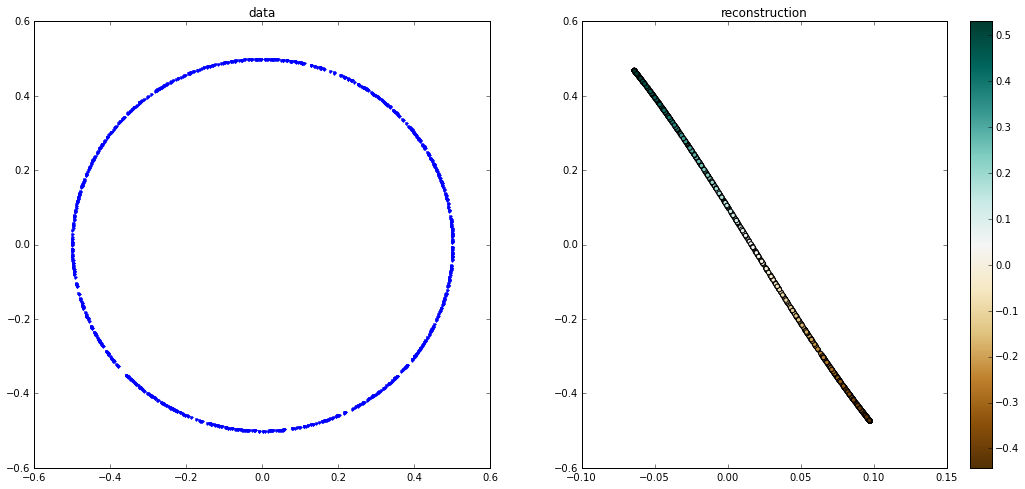

In [611]:
data = circle([0.5,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

**Eclipse:** next we try an eclipse. The cirlce is streched in  on direction. This direction has the greatest variance and the network should capture that direction. 

(0, ' sse=', 0.1271092592612931)
(5, ' sse=', 0.0056445687662943118)
(10, ' sse=', 0.0056219023470761463)
(15, ' sse=', 0.0056006144463505575)
(20, ' sse=', 0.0055806267548486818)
(25, ' sse=', 0.0055618393100177821)
(30, ' sse=', 0.0055441615004470871)
(35, ' sse=', 0.005527511160851247)


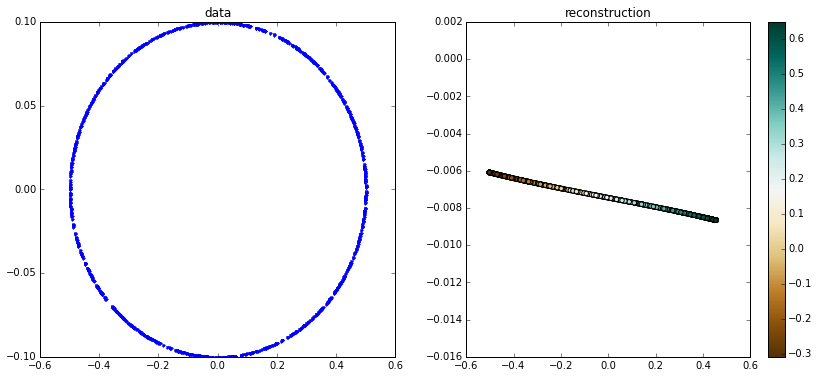

In [619]:
data = circle([0.5,0.1],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

### Training a sphere

(2, 3)
(0, ' sse=', 0.30879888804073768)
(5, ' sse=', 0.26611861909271484)
(10, ' sse=', 0.26611817702392859)
(15, ' sse=', 0.26611817680958461)


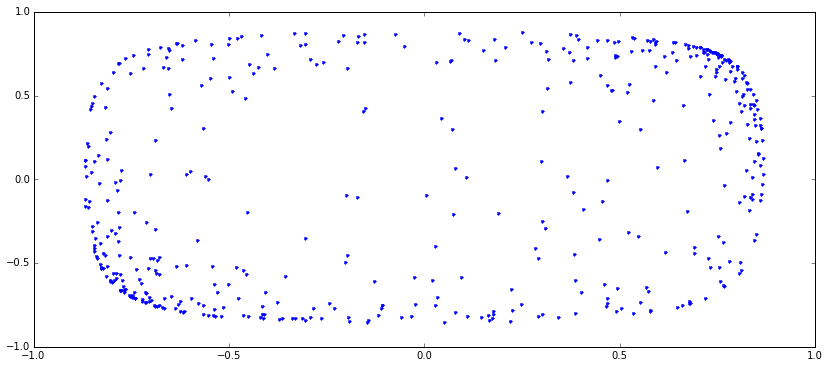

In [621]:
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
print ae.w.shape
ae.train(data, epochs=20, callback = cb_print)
hidden = ae.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
reconstructed = ae.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
# plot the encoded points
fig, ax = plt.subplots()
ax.plot(hidden[0],hidden[1],".")
fig.show()

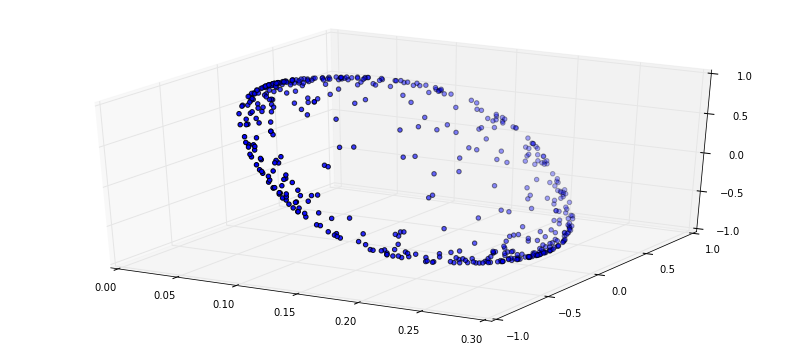

In [622]:
#show the reconstructed examples. 
scatter3D(reconstructed).show()

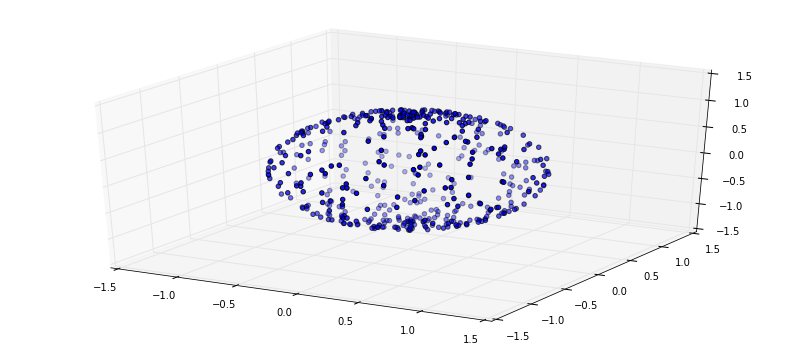

In [623]:
#and the original data
scatter3D(data).show()

### Functional Testing stuff (deprecated) 

In [503]:
data = sphere([1.0,1.0,1.0],1)[:,0]
print data
w = np.array([[0.1,0.2,0.3], [0.2, 0.3, 0.4]])
b = np.array([0.3, 0.4])
b_rec = np.array([0.3, 0.4, 0.5])
eta = 0.1
ys = out(data,w,b) # input to hidden layer activatio
zs = out(ys,w.T,b_rec) # hidden layer to output layer activation. Note that the weights are shared
err = data.T - zs # error at the ouput layer    
b_rec_n = b_rec + eta * (1 - zs**2) * err # update the bias terms into the reconstruction layer
dwt = eta * np.matrix(((1 - zs**2) * err)).T * np.matrix(ys) 
err_h = np.sum(w * err,1)
b = b + eta * (1 - ys**2) * err_h
w = w + eta * np.matrix((1 - ys**2) * err_h).T * np.matrix(data) #

[-0.78008208 -0.625526   -0.01375399]


In [505]:
print w.shape
print data.shape


(2, 3)
(3,)


In [509]:
print w, type(w)

[[ 0.13631487  0.22911988  0.30064028]
 [ 0.25704243  0.34574073  0.40100574]] <class 'numpy.matrixlib.defmatrix.matrix'>


In [508]:
print data, type(data)

[-0.78008208 -0.625526   -0.01375399] <type 'numpy.ndarray'>
